## Part 1: Clustering

In [507]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy.cluster.hierarchy import dendrogram, linkage, leaves_list
from statsmodels.stats.multitest import fdrcorrection

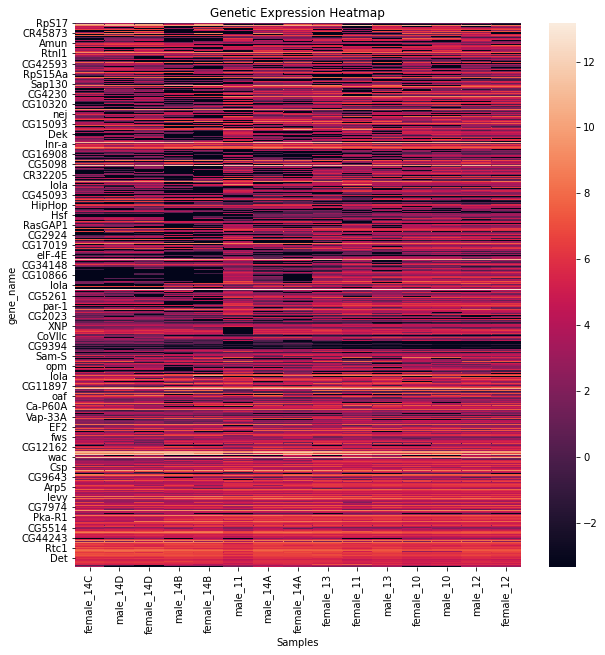

In [508]:
fpkm = pd.read_csv('all_annotated.csv')


##log2(FPKM+1) transformation:

fpkm['Keep']=np.where(fpkm.median(axis=1,numeric_only=True)>0,True,False)
fpkm = fpkm.loc[fpkm['Keep'] == True]
log_fpkm=fpkm.apply(lambda x:np.log2(x+0.1) if np.issubdtype(x.dtype, np.number) else x)
log_fpkm=log_fpkm.drop(['Keep'], axis = 1)
log_fpkm

#clustering data matrix

cluster_data = log_fpkm.values
cluster_data_ntg = np.delete(cluster_data,(0,1),1)
cluster_data_ntg_transposed = np.transpose(cluster_data_ntg)
z = linkage(cluster_data_ntg)
z_transposed = linkage(cluster_data_ntg_transposed)


gene_labels = leaves_list(z)
gene_names = []
sample_labels = leaves_list(z_transposed)
column_names = []
for n in gene_labels:
    gene_names.append(cluster_data[n][1])
    
cols = log_fpkm.columns.tolist()[2:]
for p in sample_labels:
    column_names.append(cols[p])

#heatmap generation

log_fpkm = log_fpkm.set_index('gene_name')
log_fpkm_gn = log_fpkm.loc[gene_names]
fig, ax= plt.subplots(figsize=(10,10))
log_fpkm_cn = log_fpkm_gn[column_names]

ax=sns.heatmap(log_fpkm_cn.iloc[:, 1:])
ax.set_title("Genetic Expression Heatmap")
ax.set_xlabel("Samples")
plt.show()



## Making the dendrogram

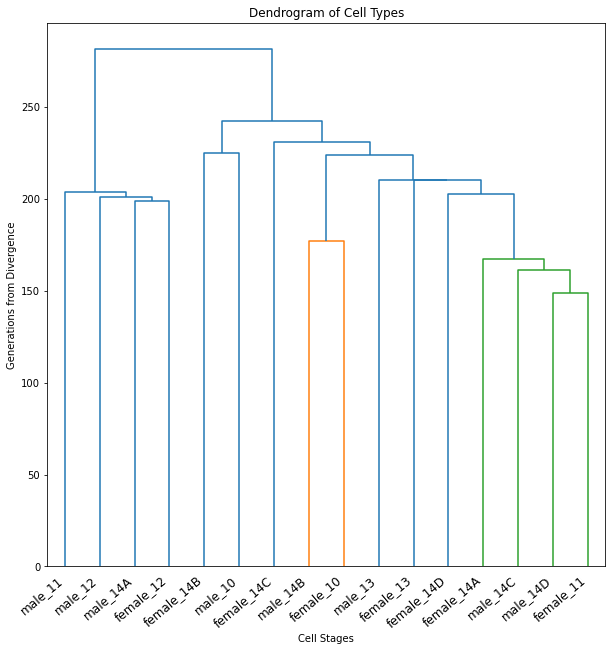

In [509]:
fig, ax= plt.subplots(figsize=(10,10))
dendrogram(z_transposed, labels = column_names)
plt.xticks(rotation=40, ha='right')
ax.set_title('Dendrogram of Cell Types')
ax.set_xlabel('Cell Stages')
ax.set_ylabel('Generations from Divergence')
plt.show()

## Part 2: Differential expression

In [510]:
#OLS Regression for genes differentially expressed across stages

log_fpkm_dropped=log_fpkm.set_index('t_name')
log_fpkm_dropped

sex_list = log_fpkm_dropped.columns
sex_list_nn = []
day_list = []

for n in sex_list:
    if 'fe' in n:
        sex_list_nn.append('female')
        
        if 'A'in n or 'B' in n or 'C' in n or 'D' in n:
            day_list.append(int(n[-3:-1]))
        else: 
            day_list.append(int(n[-2:]))
        
    else:
        sex_list_nn.append('male')
        
        if 'A'in n or 'B' in n or 'C' in n or 'D' in n:
            day_list.append(int(n[-3:-1]))
        else: 
            day_list.append(int(n[-2:]))
        
sex_list_nn
day_list

log_fpkm_dropped.loc['sex'] = sex_list_nn
log_fpkm_dropped.loc['age'] = day_list


log_fpkm_transtest = log_fpkm_dropped.transpose()
log_fpkm_transtest







t_name,FBtr0302347,FBtr0113885,FBtr0301810,FBtr0113895,FBtr0345179,FBtr0301812,FBtr0113990,FBtr0113989,FBtr0078962,FBtr0078964,...,FBtr0100870,FBtr0100877,FBtr0100879,FBtr0100884,FBtr0100886,FBtr0100888,FBtr0114261,FBtr0114216,sex,age
male_10,4.57365,3.47212,4.26062,2.68161,6.89997,2.70509,4.75646,3.14647,-3.32193,3.46393,...,-3.32193,2.77647,3.49208,5.06356,4.6616,11.1919,-2.5348,1.07806,male,10
male_11,3.59309,-3.32193,-3.32193,2.01271,3.55226,-3.32193,-3.32193,-3.32193,-3.32193,4.23906,...,-3.32193,-1.47013,-1.02401,0.20933,-0.437467,5.09509,-3.32193,-3.32193,male,11
male_12,4.38319,-3.32193,3.90037,2.66547,6.90974,3.38764,-3.32193,4.65375,-3.32193,4.67025,...,-3.32193,3.67005,2.11786,3.31221,4.41827,9.8575,-2.34821,3.01688,male,12
male_13,3.77261,-3.32193,4.80188,6.13017,6.24561,4.52975,4.85263,4.09329,-3.32193,4.08372,...,-3.32193,5.76376,6.54958,8.69687,9.01452,12.2717,-2.30182,1.11383,male,13
male_14A,4.24048,3.89776,4.4848,6.07272,6.18816,4.65837,4.89247,2.50752,3.46578,4.07881,...,5.24796,5.72629,6.44864,6.6813,8.35056,11.1365,-3.32193,1.69674,male,14
male_14B,4.74968,-3.32193,2.9903,2.94598,6.95361,4.43548,-3.32193,-3.32193,4.83997,-3.32193,...,-3.32193,2.67673,4.50141,4.67518,5.77831,9.21394,-3.32193,-3.32193,male,14
male_14C,4.51853,4.14581,3.80107,6.23034,6.34579,5.11012,4.42178,-3.32193,6.83412,3.48419,...,5.11985,5.72382,6.19377,6.16692,8.49332,11.2838,-3.32193,0.695194,male,14
male_14D,3.5586,3.43687,3.70106,5.75061,5.90106,4.14388,2.42338,3.73393,7.22232,-3.32193,...,4.60372,3.96227,5.82369,6.94574,7.7975,10.6901,-2.1434,3.2158,male,14
female_10,4.45905,-3.32193,4.2227,5.48696,5.60232,3.8855,4.15723,3.63683,-3.32193,4.53384,...,2.24717,3.42726,5.37293,6.90534,8.25979,11.3326,0.00326833,3.76295,female,10
female_11,3.80963,-3.32193,1.59416,4.08186,4.1968,2.03595,-3.32193,-3.32193,-3.32193,3.09516,...,-3.32193,-0.163229,-1.37436,-0.371506,1.17224,6.26032,-3.32193,0.904145,female,11


## Converting values back to float in dataset

In [511]:
# Converting values back to float in the dataset

for f in log_fpkm_transtest.columns:
    if 'sex' in str(f):
        pass
    else:
        log_fpkm_transtest[f] = pd.to_numeric(log_fpkm_transtest[f], errors = 'coerce')




## OLS Testing

In [512]:
# OLS Testing

pvalued = []

for t__name in log_fpkm_transtest.columns:
    
    if 'sex' in t__name or 'age' in t__name:
        pass
    else:
        model = smf.ols(formula = str(t__name + ' ~ age'), data = log_fpkm_transtest)
        results=model.fit()

        array1 = np.array(results.pvalues)
        pvalued.append([t__name, float(array1[1])])



In [513]:
#Prepping for QQ plot and false discovery rate calculations

pvalued_nosort = []
pvalued2 = []
for p in pvalued:
    pvalued_nosort.append(p[1])
    
pvalued2 = pvalued_nosort.copy()

pvalued2.sort(reverse=False)

uniform_points=[(x+1)/len(pvalued2) for x in range(len(pvalued2))]
log_uniform_points=[-1*np.log10(x) for x in uniform_points]
log_pvalues=[-1*np.log10(x) for x in pvalued2]


## QQ Plot

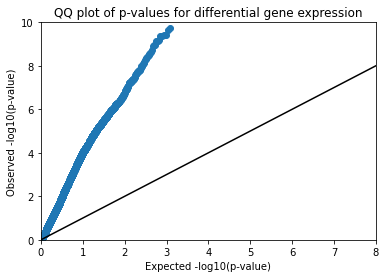

In [514]:
#QQ plot

fig, ax = plt.subplots()

ax.scatter(log_uniform_points, log_pvalues)
ax.plot([8,0], [8, 0], color = "black")

plt.xlim([0, 8])
plt.ylim([0, 10])
plt.xlabel("Expected -log10(p-value)")
plt.ylabel("Observed -log10(p-value)")
ax.set_title("QQ plot of p-values for differential gene expression")
plt.show()

## List of gene exhibiting differential expression by stage after FDR

In [515]:
corrected_fdr_values=fdrcorrection(pvalued_nosort,alpha=0.1)


corrected_genes = []
for i in range(len(corrected_fdr_values[0])):
    if corrected_fdr_values[1][i] < 0.1:
        corrected_genes.append(pvalued[i][0])

print('Number of genes significant after fdr correction: ' + str(len(corrected_genes)))

#For actual list, print corrected_genes


Number of genes significant after fdr correction: 3790


## OLS with sex covariate

In [516]:
pvalued_sex = []
beta=[]

for t___name in log_fpkm_transtest.columns:
    
    if 'sex' in t___name or 'age' in t___name:
        pass
    else:
        model = smf.ols(formula = str(t___name + ' ~ age + sex'), data = log_fpkm_transtest)
        results=model.fit()
    #results.summary()
        array_sex = np.array(results.pvalues)
        pvalued_sex.append([t___name, float(array_sex[2])])
        beta.append(results.params[2])


In [517]:
pvalued_sex_nosort = []
pvalued2_sex = []

for b in pvalued_sex:
    pvalued_sex_nosort.append(b[1])
    
pvalued2_sex = pvalued_sex_nosort.copy()

pvalued2_sex.sort(reverse=False)



## FDR Correction

In [518]:
corrected_fdr_values_sex=fdrcorrection(pvalued_sex_nosort,alpha=0.1)

significant=[]

corrected_genes_sex = []
for i in range(len(corrected_fdr_values_sex[0])):
    if corrected_fdr_values_sex[1][i] < 0.1:
        corrected_genes_sex.append(pvalued_sex[i][0])
        significant.append('Yes')
    else:
        significant.append('No')
        

print('Number of genes significant after fdr correction: ' + str(len(corrected_genes_sex)))

## To view actual list, print corrected_genes_sex

Number of genes significant after fdr correction: 3667


## Percentage overlap with and without sex covariate

In [519]:
sex_counter = 0

for gene in range(len(corrected_genes)):
    
    if corrected_genes[gene] in corrected_genes_sex:
        sex_counter +=1

percentage_overlap = ((sex_counter/(len(corrected_genes)))*100)
    

In [520]:
print('Percentage overlap: ' + str(percentage_overlap) + '%')

Percentage overlap: 96.25329815303431%


## Volcano Plot

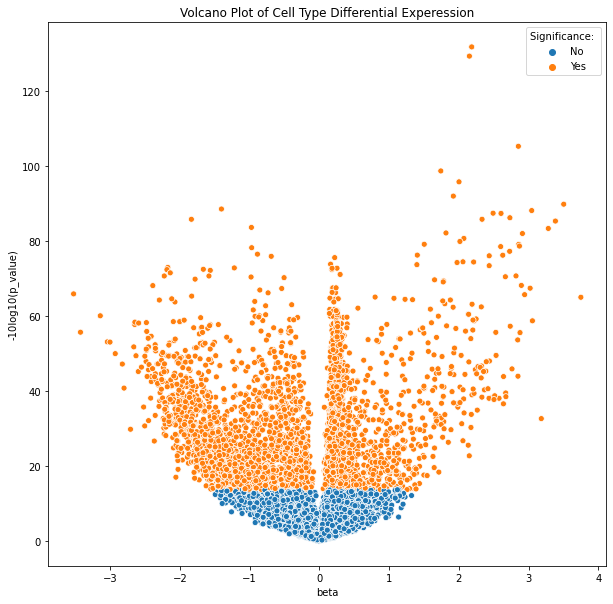

In [521]:
volcano = {'-10log10(p_value)':-10*np.log10(pvalued_sex_nosort), 'beta': beta, 'significant':significant}
volcan_data=pd.DataFrame(volcano)
volcan_data
fig,ax=plt.subplots(figsize=(10,10))
ax.set_title('Volcano Plot of Cell Type Differential Experession')

sns.scatterplot(data=volcan_data, x='beta', y='-10log10(p_value)', hue=volcan_data.significant.to_list())
plt.legend(title='Significance: ')
plt.show()

        